In [1]:
import sys
sys.path.append('/home/achint/Generative_Modelling/POISE_achint/')
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from data_loaders import MNIST_MNIST
from networks.encoders.MNIST_mlp import EncMNIST
# from networks.decoders.MNIST_mlp import DecMNIST
from networks.decoders.MNIST_pixel import DecMNIST
from networks.decoders.pixelcnn import PixelCNN

from utils.functions import train
from utils.functions import plotting
from model.poise_vae import POISE_VAE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"
PATH = "/home/achint/Generative_Modelling/POISE_achint/saved_models/MNIST_MNIST_PIXEL.pt"
joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'training')
joint_dataset_test  = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'test')

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
lat1, lat2 = 20, 25
enc_mnist1 = EncMNIST(lat1).to(device)
enc_mnist2 = EncMNIST(lat2).to(device)
# dec_mnist1 = DecMNIST(lat1).to(device)
# dec_mnist2 = DecMNIST(lat2).to(device)

color_level = 256
dec_mnist1 = DecMNIST(PixelCNN(lat1, 1, color_level), color_level).to(device)
dec_mnist2 = DecMNIST(PixelCNN(lat2, 1, color_level), color_level).to(device)


In [5]:
vae = POISE_VAE([enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], latent_dims=[lat1, lat2], 
                    batch_size=batch_size,generate_mode= False).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# vae.load_state_dict(torch.load(PATH))
# vae.eval()


In [6]:
epoch = 0
epochs = 1 + epoch
for epoch in tqdm(range(epoch, epochs)):
    train(vae, train_loader, optimizer, epoch, generate_mode=False)
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],generate_mode= False)
            break

100%|█████████████████████████████████████████████| 1/1 [00:47<00:00, 47.81s/it]


## Reconstruction

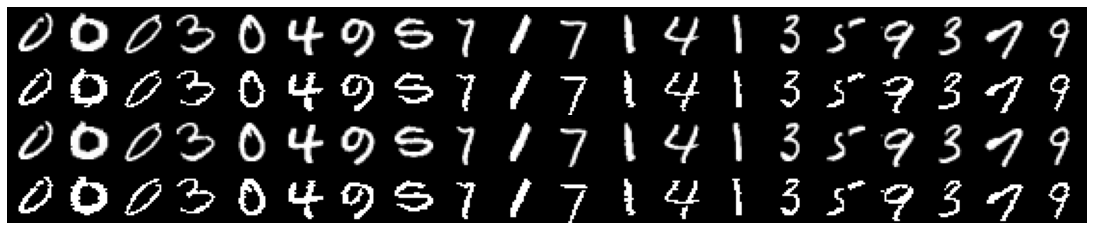

In [7]:
# plotting(vae, data, results['x_rec'])
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],generate_mode= False)
        break
x_rec = [results['x_rec'][0].max(dim=1).indices.reshape(128,784),results['x_rec'][1].max(dim=1).indices.reshape(128,784)]
plotting(vae, data, x_rec)


## Cross Generation

In [8]:
input_data1 = [data[0].to(device, dtype=torch.float32), None]
input_data2 = [None, data[1].to(device, dtype=torch.float32)]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results1 = vae(input_data1,generate_mode= True)
        results2 = vae(input_data2,generate_mode= True)
        break
input_data1[1] = torch.zeros_like(data[1]).to(device)
input_data2[0] = torch.zeros_like(data[0]).to(device)


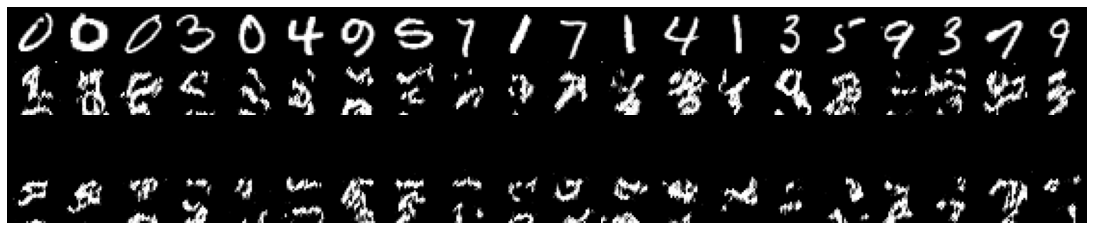

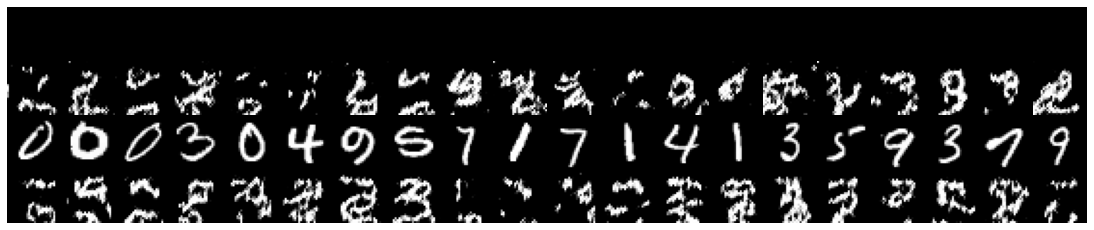

In [9]:
a = [results1['x_rec'][0],results1['x_rec'][1].flatten(-3,-1)]
b = [results2['x_rec'][0].flatten(-3,-1),results2['x_rec'][1]]

# plotting(vae, input_data1,results1['x_rec'])
# plotting(vae, input_data2,results2['x_rec'])
plotting(vae, input_data1,a)
plotting(vae, input_data2,b)

## Joint Generation

In [10]:
input_data = [None, None]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae(input_data,generate_mode= True)
        break
input_data[0] = torch.zeros_like(data[0]).to(device)
input_data[1] = torch.zeros_like(data[1]).to(device)

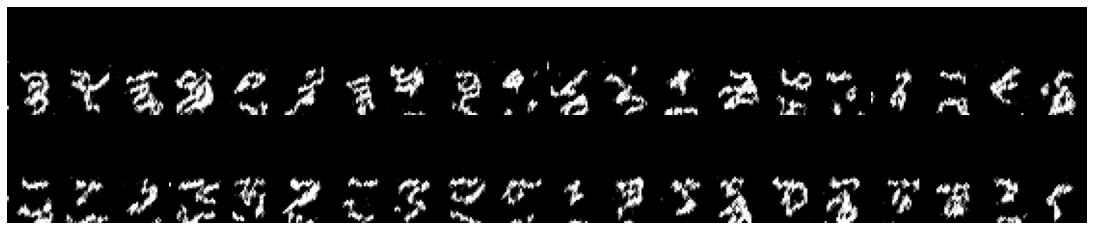

In [11]:
a=[results['x_rec'][0].flatten(-3,-1),results['x_rec'][1].flatten(-3,-1)]
plotting(vae, input_data,a)
# plotting(vae, input_data,results['x_rec'])

In [12]:
# PATH = "/home/achint/Generative_Modelling/POISE_achint/saved_models/MNIST_MNIST_PIXEL.pt"
# torch.save(vae.state_dict(), PATH)
